<a href="https://colab.research.google.com/github/vanessaaleung/Reviews-Sentiment-Classification-With-Keras/blob/master/Reviews_Sentiment_Classification_With_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Reviews Sentiment Classification With Keras**

In [0]:
import pandas as pd

In [0]:
file_dict = {'yelp':   'https://raw.githubusercontent.com/vanessaaleung/rawdata/master/text-classification/yelp_labelled.txt',
              'amazon': 'https://raw.githubusercontent.com/vanessaaleung/rawdata/master/text-classification/amazon_cells_labelled.txt',
              'imdb':   'https://raw.githubusercontent.com/vanessaaleung/rawdata/master/text-classification/imdb_labelled.txt'}

df_list = []
for source, filepath in file_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


**corpus**: collection of texts

**vocabulary**: a list of words that occurred in the text, each word has its own index



In [0]:
# vectorize sentences: takes words and creates a vocabulary of unique words
from sklearn.feature_extraction.text import CountVectorizer

sentences = ['John likes ice cream', 'John hates chocolate.']

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'chocolate': 1, 'cream': 2, 'hates': 3, 'ice': 4, 'likes': 5}

**feature vector**: each dimension can be the count of a word in a vocabulary

In [0]:
# feature vectors - bag of words model
# each document is represented as a vector
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

#### **Baseline Model - Logistic Regression**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=0)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)   # # tokenization, removing putctuation & special characters
    X_train = vectorizer.transform(sentences_train)  # sparse matrix: only keeps track of non-zero elements, reducing memory load
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.8120
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7326


#### **Neural Networks with Keras**
- At each node, you feed the value forward, while the value in multiplied by a weight and a bias is added

![alt text](https://files.realpython.com/media/njanakiev-neural-network-formula.059738905ae8.png)

- Neural Network with more than one hidden layer is consider as a deep neural network
- It is common to use a rectified linear unit (ReLU) for hidden layers, a sigmoid function for the output layer in a binary classification problem, or a softmax function for the output layer of multi-class classification problems.

The Sequential model is a linear stack of layers.

The most common layer is the Dense layer.

In [0]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) # 10 is the dimention of the output layer
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [0]:
# configure the learning process
model.compile(loss='binary_crossentropy', 
...               optimizer='adam', 
...               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25330     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,341
Trainable params: 25,341
Non-trainable params: 0
_________________________________________________________________


**epoch**: number of iterations

**batch size**: how many samples to use in one epoch - increase the speed, but also the memeory

In [0]:
# history: callback that records the loss and additional metrics
history = model.fit(X_train, y_train,
...                     epochs=100,
...                     verbose=False,
...                     validation_data=(X_test, y_test),
...                     batch_size=10)

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7326


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

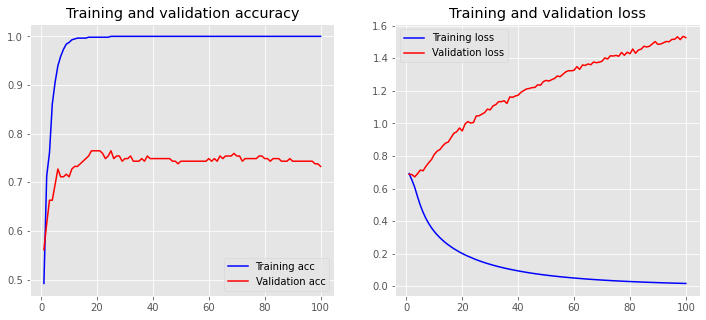

In [0]:
# x-axis: epoch
plot_history(history)

#### **Word Embeddings**
Represents words as dense word vectors(embeddings). 

Map semeantic meaning into a geometric space (embedding space)

**CountVectorizer**: returns stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). 

**Tokenizer**: the resulting vectors equal the length of each text, and the numbers correspond to the word values from the dictionary tokenizer.word_index.



In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)  # num_words: setting the vocabulary size
tokenizer.fit_on_texts(sentences_train) 

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])  # vectorize text corpus into a list of integers

20th Century Fox's ROAD HOUSE 1948) is not only quite a silly noir but is an implausible unmitigated bore of a movie.  
[986, 602, 987, 988, 989, 990, 5, 28, 64, 203, 2, 991, 603, 20, 5, 32, 604, 992, 427, 4, 2, 10]


In [0]:
# each word has an index in the dictionary
tokenizer.word_index.items()

dict_items([('the', 1), ('a', 2), ('and', 3), ('of', 4), ('is', 5), ('i', 6), ('this', 7), ('to', 8), ('it', 9), ('movie', 10), ('in', 11), ('was', 12), ('that', 13), ('film', 14), ('1', 15), ('0', 16), ('for', 17), ('as', 18), ('with', 19), ('but', 20), ('you', 21), ('on', 22), ('are', 23), ('one', 24), ('bad', 25), ("it's", 26), ('so', 27), ('not', 28), ('just', 29), ('all', 30), ('very', 31), ('an', 32), ('about', 33), ('good', 34), ('by', 35), ('from', 36), ('his', 37), ('at', 38), ('if', 39), ('be', 40), ('there', 41), ('out', 42), ('he', 43), ('have', 44), ('like', 45), ('acting', 46), ('has', 47), ('who', 48), ('even', 49), ('really', 50), ('or', 51), ('great', 52), ('time', 53), ('characters', 54), ('well', 55), ('see', 56), ('my', 57), ('how', 58), ('more', 59), ('were', 60), ('when', 61), ('10', 62), ('most', 63), ('only', 64), ('no', 65), ('can', 66), ('story', 67), ('plot', 68), ('some', 69), ("didn't", 70), ('made', 71), ('because', 72), ('do', 73), ('real', 74), ('would',

As each sequence has different lengths, use `pad_sequence()` to pads the sequence of words with zeros

In [0]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100  # the length of the sequences, cut sentences that exceed

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[2, :])

[986 602 987 988 989 990   5  28  64 203   2 991 603  20   5  32 604 992
 427   4   2  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


#### **Keras Embedding Layer**

In [0]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           130050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 180,071
Trainable params: 180,071
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.6524


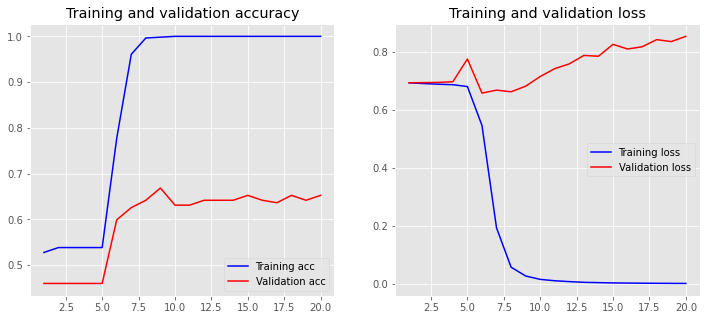

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Max pooling: take the maximum value of all features in the pool for each feature dimension.

In [0]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           130050    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 130,571
Trainable params: 130,571
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7701


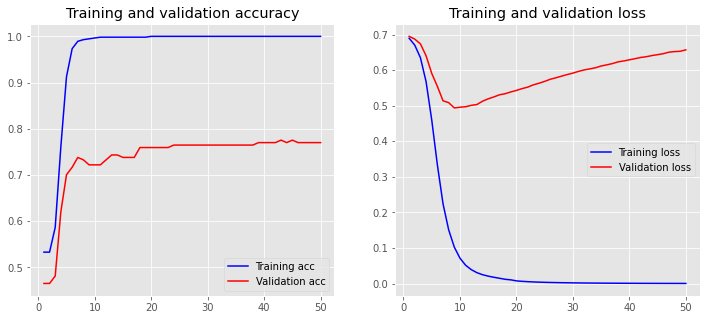

In [0]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### **Convolutional Neural Networks (CNN)**

- Convolutional layers
 - detect edges, corners and other textures
 - Consist of multiple filters which are alid across the image and are able to detect specific features.

- Works best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

- take a patch of input features with the size of the filter kernel
- take the dot product of the multiplied weights of the filter
![alt text](https://files.realpython.com/media/njanakiev-1d-convolution.d7afddde2776.png)

In [0]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          260100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 325,529
Trainable params: 325,529
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7647


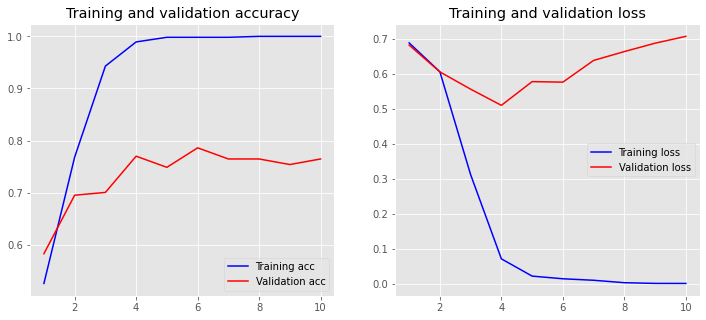

In [0]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### **Hyperparameters Optimization**

In [0]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.4min finished
